In [1]:
import matplotlib.pyplot as plt
import numpy as np, pickle, cv2
from process import *

root = "/home/kavra/Datasets/medical/cvi_eyetracking/asc_data_v1/"
trial = "Freeviewingstillimage_1.jpg"
# TODO: Perform Mann-Whitney test on CVI - ctrl

In [85]:
import numpy as np, torch
from torch.autograd import Variable
from torchvision import models, transforms
from PIL import Image

def smap_grad(img):
    model = models.densenet201(weights="DenseNet201_Weights.DEFAULT")
    smap = smooth_integrated_gradients(model, img)
    return (smap - smap.min()) / (smap.max() - smap.min())**2

def smooth_integrated_gradients(model, img, step_size=1/256):
    """
    Generates a saliency map based on the Smooth Integrated Gradients method.
    
    Parameters:
        model (torch.nn.Module): The model for which the saliency map should be generated.
        input_image (torch.Tensor): The input image for which the saliency map should be generated.
        num_samples (int): The number of samples to use when averaging the gradients.
        step_size (float): The step size to use when computing the gradients.
    
    Returns:
        saliency_map (torch.Tensor): The generated saliency map.
    """
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    img = Image.fromarray(np.uint8(img))
    input_image = transform(img)
    input_image = Variable(input_image, requires_grad=True)
    baselines = torch.zeros_like(input_image)
    
    total_gradients = None
    for _ in range(3):
        noise = np.random.rand(*input_image.shape)
        noise = (noise - 0.5) * 2 * step_size
        noise = torch.tensor(noise, dtype=input_image.dtype)
        baselines = baselines + noise

        this_image = input_image + baselines
        this_image.retain_grad()
        model_output = model(this_image.unsqueeze(0))
        model_output.retain_grad()
        model_output.max().backward(retain_graph=True)
        
        gradients = this_image.grad.data
        if total_gradients is None:
            total_gradients = gradients
        else:
            total_gradients = total_gradients + gradients
        this_image.grad.data.zero_()
    
    saliency_map = np.abs(total_gradients.detach().numpy() / 3)
    saliency_map = np.sum(saliency_map, axis=0)
    
    return saliency_map


In [86]:
img = plt.imread("trials/Trial_61/Freeviewingstillimage_12.jpg")

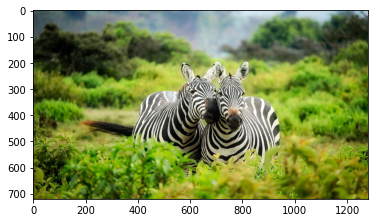

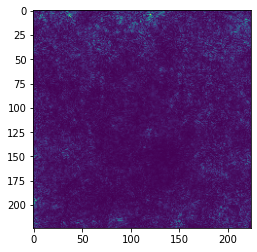

In [87]:
plt.imshow(img)
plt.show()
plt.imshow(smap_grad(img))
plt.show()

In [11]:
sub0 = Subject(root, "1003_3")
data0, fr0 = sub0.extract_data(trial, vel=False)
out = sub0.extract_saccades(trial_name=trial)

In [5]:
fix_analyzer = FixationAnalyzer(root, out)
a = fix_analyzer.fixation_map(trial)

In [6]:
ids = [i for i in os.listdir(root) if i.endswith('.asc')]
ctrl_ids = [i.split(".")[0] for i in ids if i.split('_')[0].startswith("2")]
cvi_ids = [i.split(".")[0] for i in ids if i not in ctrl_ids]

durations_ctrl = []
for subject in ctrl_ids:
    sub = Subject(root, subject)
    out = sub.extract_fixations(trial_name=trial)
    fix_analyzer = FixationAnalyzer(root, out)
    dur = fix_analyzer.number_of_fixations()
    durations_ctrl.append(dur)

durations_cvi = []
for subject in cvi_ids:
    sub = Subject(root, subject)
    out = sub.extract_fixations(trial_name=trial)
    fix_analyzer = FixationAnalyzer(root, out)
    dur = fix_analyzer.number_of_fixations()
    durations_cvi.append(dur)

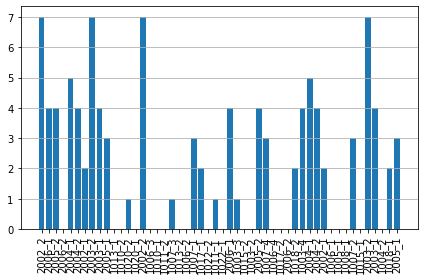

In [34]:
names = ctrl_ids + cvi_ids
t = list(range(len(names)))

plt.bar(t, durations_ctrl + durations_cvi)
plt.xticks(t, names, rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [7]:
from scipy.stats import ttest_ind

print(np.mean(durations_cvi), np.mean(durations_ctrl))

stat, p_value = ttest_ind(durations_ctrl, durations_cvi)
print(p_value)

1.575 4.0
0.0015258557743406044


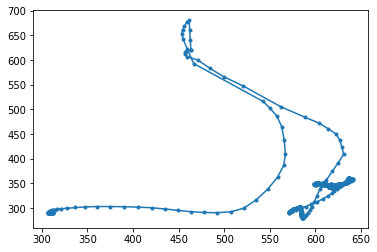

In [12]:
plt.plot(data0[:, 0], data0[:, 1], marker=".");

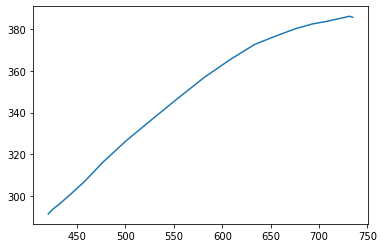

In [42]:
plt.plot(out[0]["data"][:, 0], out[0]["data"][:, 1]);

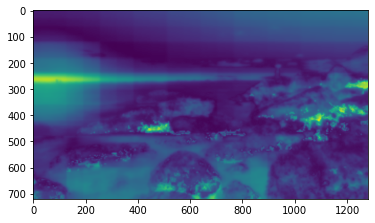

In [40]:
smap = np.load(os.path.join("output/extra", "saliency_maps", trial[:-4], trial[:-4] + "_color.npy"))
smap = (smap - np.min(smap))/(np.max(smap) - np.min(smap))
plt.imshow(smap);